In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras import backend as K

import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import r2_score as r2

In [36]:
PATH = "/home/nicolas/Documents/trabalhos/cvp_nn/nonrect3dlattice"

X, y, G = np.load(f"{PATH}/points_radii_data_500k_1.npz")["points"], np.load(f"{PATH}/points_radii_data_500k_1.npz")["radii"], np.load(f"{PATH}/points_radii_data_500k_1.npz")["G"][0]

In [37]:
J = G # np.array([[1, 0.5], [0, np.sqrt(3)/2]])
J_as_input = J.flatten("C")
q = 10 # output radii

In [38]:
aux = np.zeros(np.array(X.shape)+[0,len(J_as_input)])
aux[:,:X.shape[1]] = X
aux[:,X.shape[1]:] = J_as_input
X = aux
y = y[:,:q]

In [39]:
lattice_range = range(-10, 11)
global lattice
lattice = np.array([[i, j, k]@J
                   for i in lattice_range 
                   for j in lattice_range
                   for k in lattice_range])

In [40]:
def points_within(r, y):
    tof = np.linalg.norm(lattice-y, axis = 1) <= r 
    return lattice[tof]

def get_radius(lp, y):
    return np.linalg.norm(lp-y, axis = 1)


# NN

In [49]:
def _crelu(x):
    return K.relu(x) - K.relu(x-1)

In [61]:
model = Sequential()
model.add(Dense(500, input_dim = X.shape[1], activation = _crelu))
# model.add(Dense(128, input_dim = 500, activation = "sigmoid"))
# model.add(Dense(1000, input_dim = 128, activation = "relu"))
model.add(Dense(q, input_dim = 100))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               6500      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 11,510
Trainable params: 11,510
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(X, y, epochs = 40, batch_size = 200)

Epoch 1/40
500/500 [==============================] - 0s 585us/step - loss: 2.0101
Epoch 2/40
500/500 [==============================] - 0s 508us/step - loss: 0.0736
Epoch 3/40
500/500 [==============================] - 0s 523us/step - loss: 0.0236
Epoch 4/40
500/500 [==============================] - 0s 526us/step - loss: 0.0110
Epoch 5/40
500/500 [==============================] - 0s 594us/step - loss: 0.0070
Epoch 6/40
500/500 [==============================] - 0s 579us/step - loss: 0.0058
Epoch 7/40
500/500 [==============================] - 0s 551us/step - loss: 0.0052
Epoch 8/40
500/500 [==============================] - 0s 540us/step - loss: 0.0049
Epoch 9/40
500/500 [==============================] - 0s 548us/step - loss: 0.0047
Epoch 10/40
500/500 [==============================] - 0s 511us/step - loss: 0.0045
Epoch 11/40
500/500 [==============================] - 0s 511us/step - loss: 0.0050
Epoch 12/40
500/500 [==============================] - 0s 513us/step - loss: 0.0042
E

In [33]:
model.save(f"{PATH}/model_500k_1.h5", include_optimizer=True)

In [50]:
model = keras.models.load_model(f'{PATH}/model_500k_1.h5', custom_objects={"_crelu":_crelu})

In [51]:
X_test, y_test = np.load(f"{PATH}/points_radii_data_500k_2.npz")["points"], np.load(f"{PATH}/points_radii_data_500k_2.npz")["radii"]
# X_test, y_test = 0, 0

In [52]:
X.shape, aux.shape

((100000, 12), (100000, 12))

In [53]:
aux = np.zeros(np.array(X_test.shape)+[0,len(J_as_input)])
aux[:,:X_test.shape[1]] = X_test
aux[:,X_test.shape[1]:] = J_as_input
X_test = aux
y_test = y_test[:,:q]

In [54]:
y_pred = model.predict(X_test)

In [55]:
df = pd.DataFrame(X[:,:3], columns = ["x","y", "z"])
for i in range(q):
    df[f"r{i}"] = y[:,i]

In [56]:
a = []
for i in range(100_000):
    a.append(points_within(df["r0"].iloc[i], [df["x"].iloc[i],df["y"].iloc[i],df["z"].iloc[i]]))
df["cvp"] = a
a = []

In [57]:
df

,x,y,z,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,cvp
0,-8.329645,-6.037095,13.731002,8.974252,9.031680,9.042737,9.060110,9.082163,9.082334,9.115301,9.162612,9.173703,9.212668,"[[-6.0, 0.4641016151377544, 8.0]]"
1,4.333589,12.462572,24.839404,1.471709,1.686634,1.856457,2.015994,2.031068,2.183489,2.350222,2.363490,2.418763,2.502977,"[[5.0, 11.160254037844386, 25.0]]"
2,6.710094,14.344761,25.667140,2.147607,2.224072,2.228657,2.302432,2.505581,2.575390,2.599524,2.663044,2.698292,2.763236,"[[8.0, 12.660254037844386, 26.0]]"
3,3.849773,11.329495,27.951312,2.922413,3.172051,3.393977,3.666486,3.690559,3.705778,3.797592,4.010402,4.118802,4.243544,"[[6.0, 11.660254037844386, 26.0]]"
4,9.283652,-0.151439,11.565331,0.610439,0.709436,0.752402,0.834728,0.839101,0.913649,1.173305,1.227725,1.237553,1.289264,"[[9.0, 0.16987298107780724, 12.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,7.191493,0.204618,11.702688,0.391829,0.747601,0.781856,0.922943,1.008303,1.013918,1.093509,1.121250,1.197249,1.243777,"[[7.0, 0.035898384862245614, 12.0]]"
99996,7.200622,5.837245,33.830864,8.884221,8.884552,8.920392,8.955528,9.008734,9.010629,9.044178,9.098646,9.149399,9.310285,"[[9.0, 12.294228634059948, 28.0]]"
99997,2.629041,-2.768519,21.089268,8.315932,8.368846,8.393922,8.398799,8.408734,8.446984,8.491328,8.513342,8.536297,8.555021,"[[5.0, 3.3660254037844384, 16.0]]"
99998,-4.003740,4.367925,28.545485,10.243934,10.339102,10.367225,10.609968,10.646871,10.652634,10.701426,10.777951,10.903476,10.999455,"[[1.0, 9.160254037844386, 21.0]]"


In [58]:
df_pred = pd.DataFrame(X_test[:,:3], columns = ["x", "y", "z"])
for i in range(1):
    df_pred["least radius"] = y_test[:,0]
for i in range(q):
    df_pred[f"pred r{i}"] = y_pred[:,i]

In [59]:
df_pred

,x,y,z,least radius,pred r0,pred r1,pred r2,pred r3,pred r4,pred r5,pred r6,pred r7,pred r8,pred r9
0,4.025789,4.289406,21.678229,3.196999,3.190875,3.268336,3.335296,3.387387,3.457031,3.521217,3.589978,3.628683,3.686384,3.747519
1,6.763921,5.830636,27.272896,4.854528,4.910108,4.951484,5.006380,5.007431,5.038415,5.098791,5.152728,5.182190,5.236789,5.280094
2,-4.590208,-6.945019,12.143309,7.657063,7.687008,7.674501,7.709354,7.710976,7.750482,7.791260,7.808186,7.829338,7.857284,7.898693
3,-5.142389,-5.767444,-1.850698,0.285027,0.447359,0.659042,0.803522,0.903505,0.973228,1.031714,1.115214,1.163966,1.220549,1.260783
4,-1.710039,6.723634,23.175644,4.093830,4.108149,4.229180,4.419278,4.551248,4.588962,4.735636,4.805386,4.888073,4.959553,5.034289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-6.811534,-2.148081,9.957685,3.363720,3.413909,3.462226,3.518295,3.563010,3.632043,3.704975,3.786692,3.823229,3.867982,3.931052
99996,9.824795,15.779154,28.347193,2.154293,2.039011,2.163177,2.463960,2.604278,2.601006,2.846907,2.999172,3.220588,3.349410,3.439430
99997,9.270172,9.719125,24.965048,0.273390,0.483776,0.721537,0.839583,0.986364,1.059358,1.131904,1.196578,1.254124,1.323629,1.399434
99998,5.270461,0.072519,16.237266,2.512500,2.542310,2.624226,2.727868,2.764045,2.858229,2.925295,2.991595,3.040998,3.095120,3.140917


In [60]:
cv = []
for i in range(100_000):
    x, y, z, r = df_pred["x"].iloc[i], df_pred["y"].iloc[i], df_pred["z"].iloc[i], df_pred["least radius"].iloc[i]
    cv.append(points_within(r, [x,y,z]))
df_pred["cv"] = cv

In [61]:
pred_cv = []
for i in range(100_000):
    for j in range(q):
        x, y, z, r = df_pred["x"].iloc[i], df_pred["y"].iloc[i], df_pred["z"].iloc[i], df_pred[f"pred r{j}"].iloc[i]
        a = points_within(r, [x,y,z])
        if len(a) != 0:
            pred_cv.append(a)
            break
df_pred["pred cv"] = pred_cv

In [62]:
df_pred["len(pred cv)"] = df_pred["pred cv"].apply(len)

In [63]:
df_pred.sort_values("len(pred cv)")

,x,y,z,least radius,pred r0,pred r1,pred r2,pred r3,pred r4,pred r5,pred r6,pred r7,pred r8,pred r9,cv,pred cv,len(pred cv)
0,4.025789,4.289406,21.678229,3.196999,3.190875,3.268336,3.335296,3.387387,3.457031,3.521217,3.589978,3.628683,3.686384,3.747519,"[[5.0, 6.830127018922193, 20.0]]","[[5.0, 6.830127018922193, 20.0]]",1
60698,0.525999,3.924083,26.997238,7.741546,7.746367,7.777801,7.823341,7.841816,7.852184,7.912935,7.958189,7.995591,8.057965,8.109867,"[[3.0, 9.294228634059948, 22.0]]","[[3.0, 9.294228634059948, 22.0]]",1
60694,-4.915336,8.687133,21.717833,4.795213,4.801250,4.884874,5.152898,5.394781,5.473530,5.547376,5.613696,5.665116,5.718534,5.836630,"[[-1.0, 8.160254037844386, 19.0]]","[[-1.0, 8.160254037844386, 19.0]]",1
60693,0.354508,-0.903888,17.525312,5.324990,5.348722,5.377548,5.428807,5.434188,5.475994,5.522848,5.576542,5.594387,5.649931,5.696134,"[[2.0, 2.732050807568877, 14.0]]","[[2.0, 2.732050807568877, 14.0]]",1
60692,6.173651,11.942091,39.110017,10.029230,10.077809,10.614400,10.909326,10.993170,11.269960,11.492528,11.563807,11.772664,11.836382,11.929771,"[[10.0, 13.660254037844386, 30.0]]","[[10.0, 13.660254037844386, 30.0]]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71507,9.416324,12.727295,26.477319,0.756962,0.397790,0.586645,0.729642,0.803070,0.902928,0.982286,1.028513,1.082063,1.162666,1.215214,"[[10.0, 12.794228634059948, 26.0]]","[[9.0, 12.294228634059948, 26.0], [9.0, 12.294...",6
33549,8.604051,-0.226041,11.507840,0.745483,0.502136,0.662697,0.820755,0.920532,1.002937,1.060322,1.110515,1.147632,1.192981,1.259899,"[[9.0, 0.16987298107780724, 12.0]]","[[8.0, -0.33012701892219276, 11.0], [8.0, -0.3...",6
81656,4.412488,10.237855,20.531276,0.753692,0.446454,0.673792,0.814366,0.898888,0.973647,1.028899,1.094268,1.152311,1.217000,1.260107,"[[5.0, 10.294228634059948, 21.0]]","[[4.0, 9.794228634059948, 20.0], [4.0, 9.79422...",6
29910,-3.407159,-0.222657,5.497852,0.763425,0.467727,0.682480,0.807816,0.908416,0.970755,1.033445,1.101859,1.159034,1.199302,1.248350,"[[-3.0, -0.6339745962155614, 5.0]]","[[-4.0, -0.2679491924311228, 5.0], [-4.0, -0.2...",6


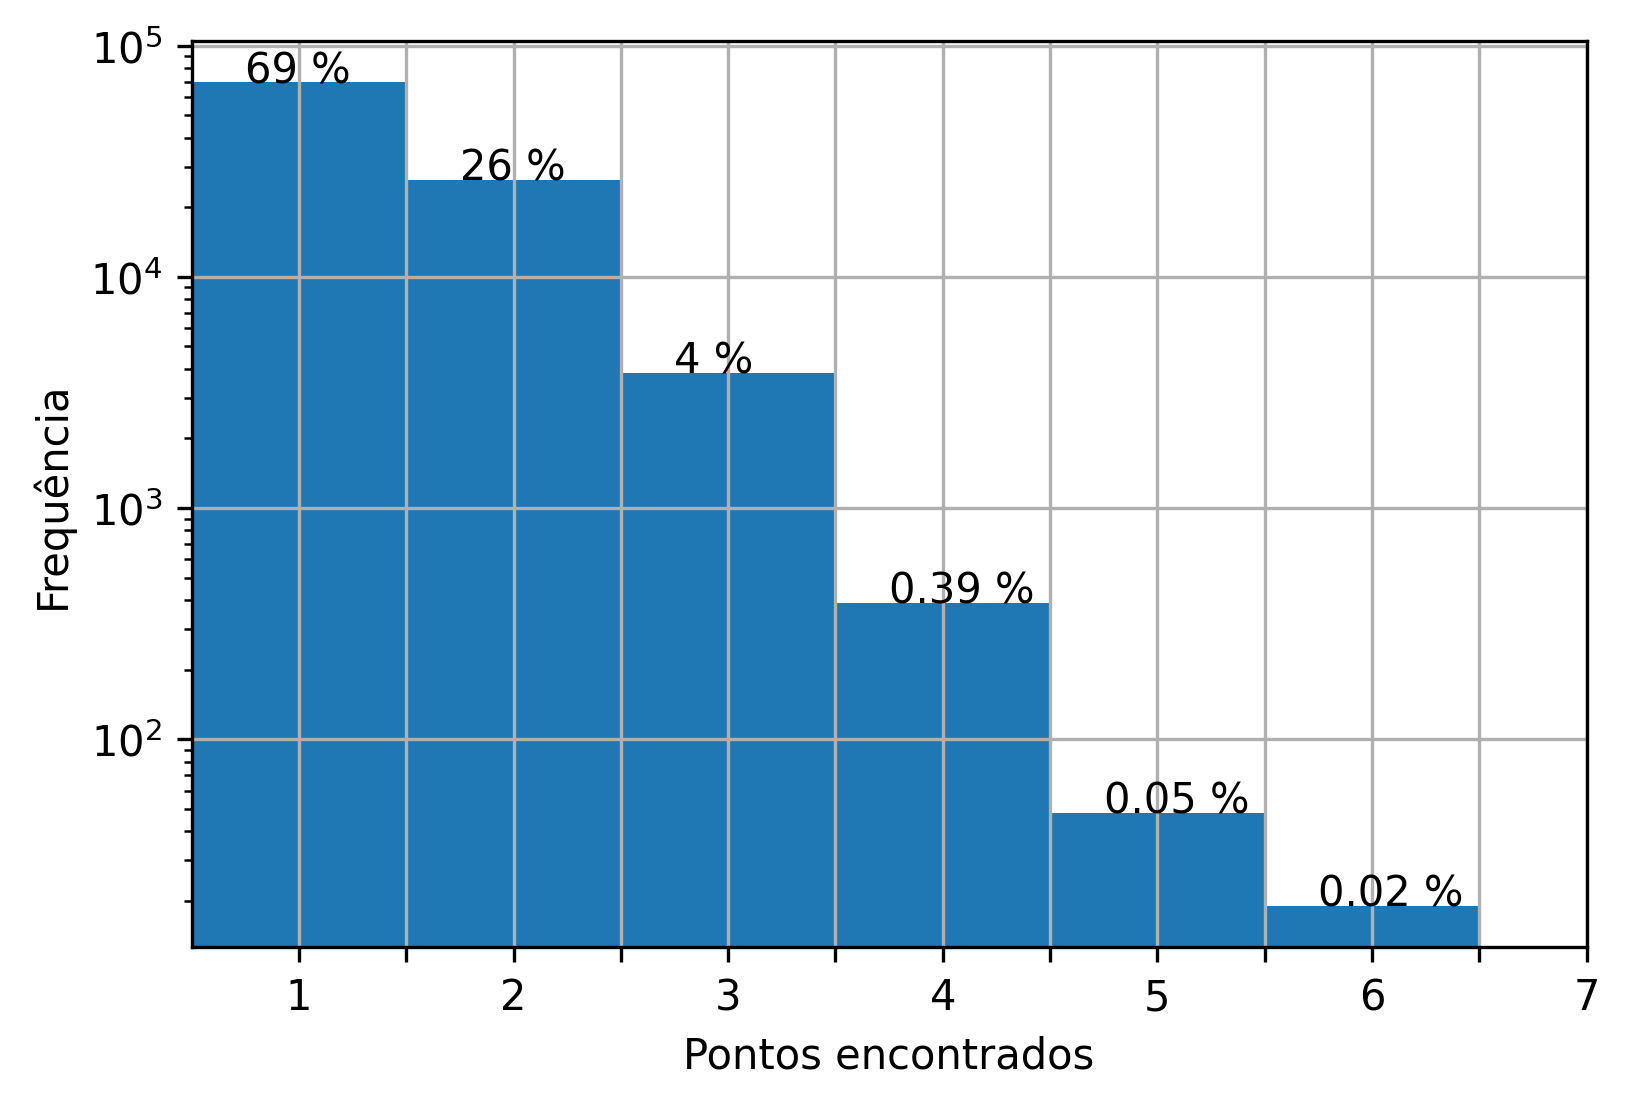

In [121]:
plt.figure(dpi=300)
plt.grid(True)
plt.xlabel("Pontos encontrados")
plt.ylabel("Frequência")
height, center = plt.hist(df_pred["len(pred cv)"], bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5], histtype = "stepfilled", align="left")[0:2]
# [plt.axhline(h, xmin = (w-1)/3, xmax = w/3, c="black") for h,w in zip(height, center)]
# [plt.axvline(w+0.5, ymin = 0, ymax = h/60000, c="black") for h,w in zip(height, center)]
percents = [i/100000 for i in height]

plt.xlim([0,6.5])
# plt.ylim([0,1000])
plt.xticks([0.5*i for i in range(1,14)],[1,'',2,'',3,'',4,'',5,'',6,'',7])
plt.yscale('log')
# plt.yticks([10_000*i for i in range(8)],[f'{10*i}%' for i in range(8)])

for i in range(0,3):
    plt.annotate(f"{100*percents[i]:.0f} %", (0.25+i,height[i]))
for i in range(3,6):
    plt.annotate(f"{100*percents[i]:.2f} %", (0.25+i,height[i]))


plt.savefig("/home/nicolas/Dropbox/USP/Doutorado/quali/apresentacao/figs/hist_nn_nonr3d.png")

In [122]:
center

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

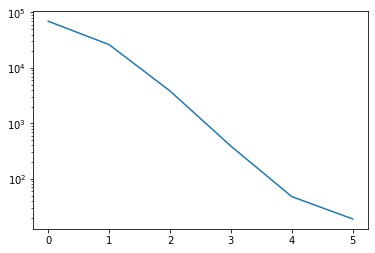

In [120]:
plt.semilogy(range(6), height)